In [107]:
import torch
import pandas as pd
import numpy as np
import random

from safetensors.torch import load_file
from esm.models.esm3 import ESM3
from transformers import AutoModel
from esm.sdk.api import ESMProtein, GenerationConfig, LogitsConfig
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

In [2]:
base_model = ESM3.from_pretrained("esm3-open", device=torch.device("cuda:2"))
finetuned_model = ESM3.from_pretrained("esm3-open", device=torch.device("cuda:2"))

Fetching 22 files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2033.20it/s]
/home/av47/miniconda3/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any

In [3]:
def load_weights(path, model):
    state_dict = torch.load(path, map_location="cuda:1")
    new_dict = {}
    
    for k, v in state_dict.items():
        if k in model.state_dict():
            new_dict[k] = v
    model.load_state_dict(new_dict)

In [114]:
load_weights("weights/20241201-151535/checkpoint-22923/pytorch_model.bin", finetuned_model)

/tmp/ipykernel_3804215/2961478943.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="cuda:1")


In [85]:
def get_embeddings(model, seq):
    full_seq = f"EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYC{seq}WGQGTLVTVSS"
    protein = ESMProtein(sequence=full_seq)
    protein_tensor = model.encode(protein)
    logits = model.logits(protein_tensor, LogitsConfig(sequence=True, return_embeddings=True))
    return torch.mean(logits.embeddings[:,96:106].squeeze(0), dim=0)

In [86]:
seq_df = pd.read_csv("data/all.csv")
positive_seqs = random.sample(seq_df[seq_df.label == 1].seq.tolist(), 10000)
emb_positive_seqs = positive_seqs[:9500]
test_positive_seqs = positive_seqs[9500:]

negative_seqs = random.sample(seq_df[seq_df.label == 0].seq.tolist(), 10000)
emb_negative_seqs = negative_seqs[:9500]
test_negative_seqs = negative_seqs[9500:]

In [116]:
finetuned_positive_embeddings = torch.stack([get_embeddings(finetuned_model, seq) for seq in tqdm(emb_positive_seqs)])
finetuned_negative_embeddings = torch.stack([get_embeddings(finetuned_model, seq) for seq in tqdm(emb_negative_seqs)])

base_positive_embeddings = torch.stack([get_embeddings(base_model, seq) for seq in tqdm(emb_positive_seqs)])
base_negative_embeddings = torch.stack([get_embeddings(base_model, seq) for seq in tqdm(emb_negative_seqs)])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9500/9500 [06:30<00:00, 24.31it/s]


In [118]:
finetuned_positive_center = torch.mean(finetuned_positive_embeddings, dim=0)
finetuned_negative_center = torch.mean(finetuned_negative_embeddings, dim=0)

base_positive_center = torch.mean(base_positive_embeddings, dim=0)
base_negative_center = torch.mean(base_negative_embeddings, dim=0)

labels = ([1] * len(test_positive_seqs)) + ([0] * len(test_negative_seqs))
finetuned_pred_labels = []
base_pred_labels = []

for seq in tqdm(test_positive_seqs):
    finetuned_test_emb = get_embeddings(finetuned_model, seq)
    base_test_emb = get_embeddings(base_model, seq)
    
    finetuned_positive_dist = torch.sqrt(torch.sum((finetuned_positive_center-finetuned_test_emb)**2)).item()
    finetuned_negative_dist = torch.sqrt(torch.sum((finetuned_negative_center-finetuned_test_emb)**2)).item()

    base_positive_dist = torch.sqrt(torch.sum((base_positive_center-base_test_emb)**2)).item()
    base_negative_dist = torch.sqrt(torch.sum((base_negative_center-base_test_emb)**2)).item()
    
    if finetuned_positive_dist < finetuned_negative_dist:
        finetuned_pred_labels.append(1)
    else:
        finetuned_pred_labels.append(0)

    if base_positive_dist < base_negative_dist:
        base_pred_labels.append(1)
    else:
        base_pred_labels.append(0)

for seq in tqdm(test_negative_seqs):
    finetuned_test_emb = get_embeddings(finetuned_model, seq)
    base_test_emb = get_embeddings(base_model, seq)
    
    finetuned_positive_dist = torch.sqrt(torch.sum((finetuned_positive_center-finetuned_test_emb)**2)).item()
    finetuned_negative_dist = torch.sqrt(torch.sum((finetuned_negative_center-finetuned_test_emb)**2)).item()

    base_positive_dist = torch.sqrt(torch.sum((base_positive_center-base_test_emb)**2)).item()
    base_negative_dist = torch.sqrt(torch.sum((base_negative_center-base_test_emb)**2)).item()
    
    if finetuned_positive_dist < finetuned_negative_dist:
        finetuned_pred_labels.append(1)
    else:
        finetuned_pred_labels.append(0)

    if base_positive_dist < base_negative_dist:
        base_pred_labels.append(1)
    else:
        base_pred_labels.append(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 12.11it/s]


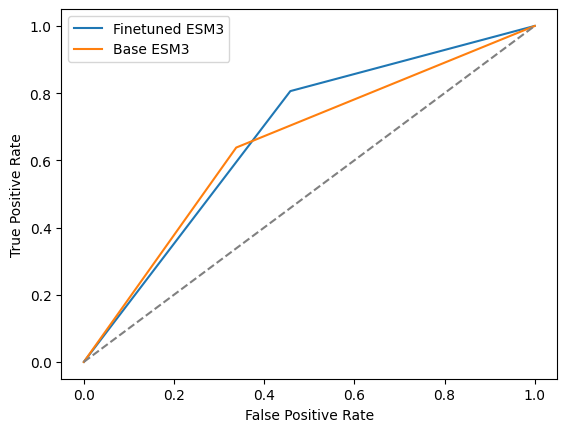

In [119]:
finetuned_fpr, finetuned_tpr, _ = roc_curve(labels, finetuned_pred_labels)
base_fpr, base_tpr, _ = roc_curve(labels, base_pred_labels)

# Step 4: Plot the ROC curve
plt.figure()
plt.plot(finetuned_fpr, finetuned_tpr, label="Finetuned ESM3")
plt.plot(base_fpr, base_tpr, label="Base ESM3")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()